# Multilinear regression and regularisation.

This exercise deals with the prediction of __avocado prices__.

1. Load the __"avocados.csv"__ file in to a pandas DataFrame. Display the first few rows of this DataFrame. The __response__ variable is contained in the `price' column, and all other columns are __predictors__. Display the price data in a way you find most appropriate. 


2. Produce a __correlation matrix__ and a __heatmap__ for the correlation from the DataFrame. Please specify which variables appear to be __highly correlated__. Compute a table of $t$__-statistics__ for each of the predictors (use regression summary table from the `StatsModels` module). You may need to convert some of the categorical predictors in a suitable form (use pd.factorize for that). Please specify the __predictors__ which appear to be __the worst__; Could you have observed all `bad' predictors by only looking at the coefficients of the correlation matrix? 


3. Fit a standard __multilinear regression model__ which uses all the predictors, and estimate the __cross validated__ root mean squared error using __10-fold cross validation__. Export your model predictions to a csv file.


4. Use the __LASSO method__ to create a lower dimensional model. Take particular care about how you choose the __shrinkage penalty__. Does your model remove any predictors or substantially alter any coefficients? If so, are the results rather expected or surprising? 


5. An avocado exporter from Israel claims that Peruvian avocados cost the same but are bigger than South African ones. Create a new DataFrame(s) only containing avocados imported from __Israel__ and __South Africa__. Generate __a scatter plot__ of avocado prices vs avocado sizes in Israel and South Africa (use different colours). Fit __a logistic regression model__ that predicts the origin of an avocado based on its size. List the probabilities of avocado of a size 400 to have originated from one of the two countries; is this result reliable?
What are the values of $\beta_0, \beta_1$? Use __Fisher information__ to compute the __standard error__ for the __regression coefficient__ and test __the hypothesis__: is there a relationship between the country of origin and the avocado size?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [52]:
df_avo = pd.read_csv('Data/avocados.csv') #imports csv
df_avo.head() #displays first 5 rows

,price,class,weight,condition,taste grade,size,age,type,origin
0,0.62,3,118.0,3,7,119.0,22,Gwen,Israel
1,0.89,3,257.0,3,7,218.0,23,Hass,Israel
2,0.58,2,77.0,3,6,78.0,29,Hass,Peru
3,0.94,4,196.0,5,7,106.0,18,Pinkerton,Peru
4,0.86,3,168.0,3,8,169.0,11,Pinkerton,Israel


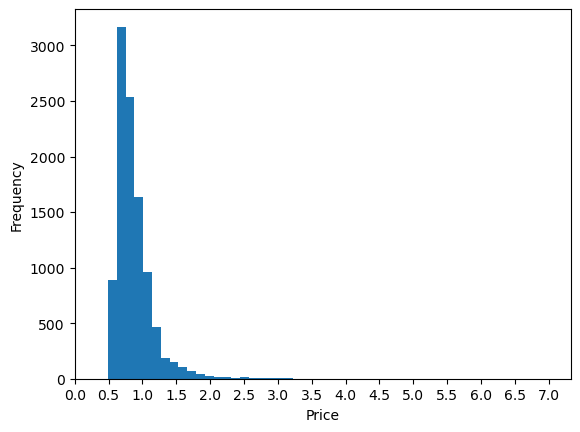

In [53]:
price_list = df_avo['price'] #isolates just the price values
#plot formatting
plt.hist(price_list,bins = 50)
plt.xticks(np.arange(0,(max(price_list)+0.5), step=0.5))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [54]:
df_avo.corr(numeric_only=True) #displays correlation matrix of df

,price,class,weight,condition,taste grade,size,age
price,1.000000,0.298642,0.700407,0.043411,0.649603,0.605501,-0.034112
class,0.298642,1.000000,0.575037,0.022019,0.362292,0.466581,-0.168227
weight,0.700407,0.575037,1.000000,-0.048833,0.762784,0.868686,-0.324888
condition,0.043411,0.022019,-0.048833,1.000000,-0.129070,-0.146167,0.315676
taste grade,0.649603,0.362292,0.762784,-0.129070,1.000000,0.760091,-0.437711
size,0.605501,0.466581,0.868686,-0.146167,0.760091,1.000000,-0.426355
age,-0.034112,-0.168227,-0.324888,0.315676,-0.437711,-0.426355,1.000000


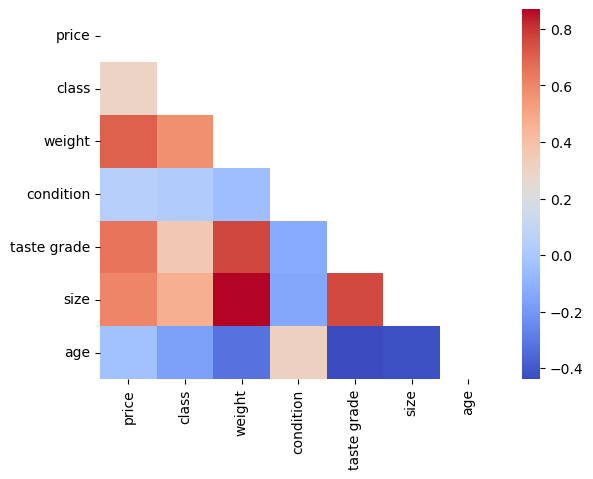

In [55]:
#plot formatting
mask = np.zeros_like(df_avo.corr(numeric_only=True), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_avo.corr(numeric_only=True),cmap="coolwarm", mask = mask)
plt.show()

In [56]:
df_avo['fac type']= pd.factorize(df_avo['type'])[0] #gives each type a unique numerical identifier instead of string
df_avo['fac origin'] = pd.factorize(df_avo['origin'])[0] #gives each origin a unique numerical identifier instead of string

X = df_avo[['class','weight','condition','taste grade','size','age','fac type','fac origin']] #list of all predictors
y = df_avo['price'] #sets price as response
X2 = sm.add_constant(X) #adds a constant term so we can use OLS regression
est = sm.OLS(y, X2) #creates input for OLS
est2 = est.fit() #performs OLS
est2.summary() #provides statistical summary from OLS regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1999.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:00:37   Log-Likelihood:                 1976.6
No. Observations:               10345   AIC:                            -3935.
Df Residuals:                   10336   BIC:                            -3870.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4310      0.023    -18.888      0.000      -0.476      -0.386
class          -0.0422      0.003    -15.855      0.000      -0.047      -0.037
weight          0.0020   5.15e-05     38.629      0.000       0.002       0.002
condition       0.0156      0.003      4.949      0.000       0.009       0.022
taste grade     0.1080      0.003     37.827      0.000       0.102       0.114
size         1.539e-06   5.34e-05      0.029      0.977      -0.000       0.000
age             0.0100      0.000     39.861      0.000       0.009       0.010
fac type       -0.0006      0.002     -0.315      0.753      -0.004       0.003
fac origin     -0.0012      0.001     -1.065      0.287      -0.003       0.001
==============================================================================
Omnibus:                     9508.294   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1068061.151
Skew:                           4.020   Prob(JB):                         0.00
Kurtosis:                      52.124   Cond. No.                     3.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The best predictors are size, type, and origin. Everything else has p-values of 0, so they are the worst. We could not have observed all the bad predictors by using the correlation matrix as condition and taste grade scored highly in the correlation matrix.

In [57]:
df_avo_numerical = df_avo.drop(columns=['type', 'origin']) #drops the string representation of type and origin from df
X = df_avo_numerical.iloc[:,1:].values #sets X to be the values from all the predictors 
y = df_avo.iloc[:,0].values #sets y to be the values for price from the df

In [58]:
def cross_validate_mlr(df_data,pred,n_folds):
    tot=0.0
    lm = LinearRegression()
    kf = KFold(n_splits=n_folds)
    
    for train_index, test_index in kf.split(X): #splits X into train sets and a test set
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
                                   
        reg = lm.fit(X_train,y_train) #Train the linear model
        y_pred = reg.predict(X_test) #predicts test y values from the x values in the test set
        root_MSE = np.sqrt(mean_squared_error(y_test,y_pred)) #finds RMSE for each fold
        tot += root_MSE #sums the RMSE values
    return tot/n_folds, y_pred #returns the average RMSE and the predicted y_values

In [59]:
RMSE, cross_y_pred = cross_validate_mlr(X,y,10) #runs CV for 10 folds using the df and assigns each output to a variable

In [60]:
df_avo_y_pred = pd.DataFrame(cross_y_pred) #creates a new df consisting of predicted y vals
df_avo_y_pred.to_csv('Avocado_price_predictions_MLR_(Q5_task 3).csv',index = False) #converts new df to csv

In [61]:
def cross_validate_lasso(df_data,alpha,k): #defines a CV funtion for the lasso method
    clf = Lasso(alpha=alpha)
    tot=0.0
    kf = KFold(n_splits=k)
    
    for train_index, test_index in kf.split(X):
        X_train_lasso, X_test_lasso = X[train_index], X[test_index]
        y_train_lasso, y_test_lasso = y[train_index], y[test_index]
        #Train the linear model
        reg = clf.fit(X_train_lasso,y_train_lasso)
        y_pred_lasso = reg.predict(X_test_lasso)
        MSE = mean_squared_error(y_test_lasso,y_pred_lasso)
        tot += MSE
    return tot/k

In [62]:
alphas = [0.05*k for k in range(1,21)] #generates a list of possible alpha values

err_list = [] #creates empty list to store MSE values in

for alpha in alphas: #iterates CV for each value in the list  above
    err = cross_validate_lasso(df_avo_numerical,alpha,10)
    err_list.append(err) #appends the error for each alpha to the MSE list

opt_alpha = 0.05*np.amin(err_list) #finds the alpha with the lowest MSE value from the list
print(opt_alpha)

0.0023269722985625493


In [63]:
clf = Lasso(alpha=opt_alpha)
clf.fit(X,y) #performs the lasso technique on our df
df_lasso = pd.DataFrame() #create new df to list the predictors and their respective coefficients
df_lasso["predictors"] = df_avo_numerical.columns[1:]
df_lasso["coeffs"] = clf.coef_
df_lasso.sort_values("coeffs",ascending=False)

,predictors,coeffs
3,taste grade,0.103546
5,age,0.009976
2,condition,0.009451
1,weight,0.002000
4,size,0.000012
6,fac type,-0.000000
7,fac origin,-0.000468
0,class,-0.038360


The lasso got rid of the predictors 'class', 'condition', 'fac type', and 'fac origin'. What is surprising is that it kept 'size' as this was one of the predictors I though was poor due to the correlation matrix.

In [64]:
avo_israel = df_avo[df_avo.origin.eq('Israel')] #rows where origin = Israel
avo_sa = df_avo[df_avo.origin.eq('South Africa')] #rows where origin = Israel
avo_comp = pd.concat([avo_israel,avo_sa]) #concatentates the above
df_avo_comp = pd.DataFrame(avo_comp) # creates a new df of avocados from either SA or Israel
df_avo_comp.head()

,price,class,weight,condition,taste grade,size,age,type,origin,fac type,fac origin
0,0.62,3,118.0,3,7,119.0,22,Gwen,Israel,0,0
1,0.89,3,257.0,3,7,218.0,23,Hass,Israel,1,0
4,0.86,3,168.0,3,8,169.0,11,Pinkerton,Israel,2,0
11,0.83,2,116.0,4,7,87.0,26,Hass,Israel,1,0
16,0.76,3,189.0,3,7,190.0,9,Pinkerton,Israel,2,0


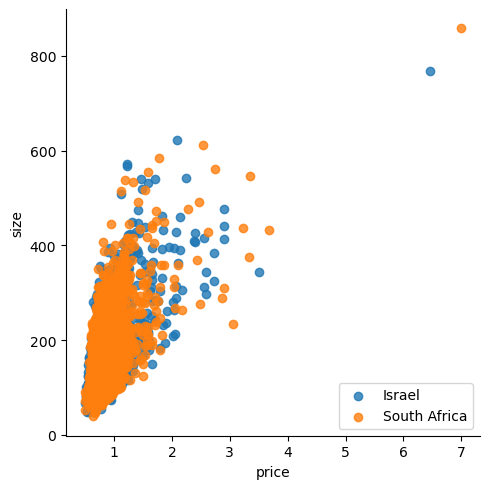

In [65]:
#plot size against price with different colours representing origins
sns.lmplot( x="price", y="size", data=df_avo_comp, fit_reg=False, hue='origin', legend=False)
plt.legend(loc='lower right')
plt.show()

In [66]:
X1 = df_avo_comp.iloc[:,[5]].values #takes values from size
Y1 = df_avo_comp.iloc[:,-1:].values #takes values from origin


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25) # creates a 75/25 train/test split in data
clf = LogisticRegression(solver='lbfgs')
lrg = clf.fit(X_train, np.ravel(y_train,order='C')) #fit logistic regression on train data
y_pred_lgr = lrg.predict(X_test) #predicts origin based on size for test data
p_test = lrg.predict_proba(X_test) #returns the probability of being from Israel/SA depending on size from test data

In [67]:
print("The probability of an avocado of size 400 being from Israel/SA = ", lrg.predict_proba([[400]]))

The probability of an avocado of size 400 being from Israel/SA =  [[0.5027 0.4973]]


In [68]:
b0 = clf.intercept_ # takes beta0 from the lgr model
b1 = clf.coef_ # takes beta1 from the lgr model
print(b0,b1) 

[0.2746] [[-0.0007]]


In [69]:
def f(x,b0,b1):
    a = np.exp(b0+b1*x)
    return a/(1.0+a)**2
    

def fisher(x_data,b0,b1): #defines the fisher information
    fvec = f(x_data,b0,b1) 
    I00 = np.sum(fvec)
    I01 = np.sum(x_data*fvec)
    I11 = np.sum(x_data**2*fvec)
    I = np.zeros((2,2))
    I[0,0] = I00
    I[0,1] = I01
    I[1,0] = I01
    I[1,1] = I11
    return I

I = fisher(X1,b0,b1) #finds the fisher information of the origin information
J = np.linalg.inv(I) #finds the inverse of the fisher information
se0 = np.sqrt(J[0,0]) #finds the standard error of beta0 estimate
se1 = np.sqrt(J[1,1]) #finds the standard error of beta1 estimate

print(se1)

0.0004160039205976668


In [70]:
#we will perform OLS regression on the origin and size data to test the hypothesis that they are correlated
X2 = sm.add_constant(X1) 
est_2 = sm.OLS(Y1, X2)
est_2 = est_2.fit()
est_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.049
Date:                Thu, 30 Mar 2023   Prob (F-statistic):             0.0809
Time:                        14:00:40   Log-Likelihood:                -8053.5
No. Observations:                3453   AIC:                         1.611e+04
Df Residuals:                    3451   BIC:                         1.612e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8342      0.100     28.318      0.000       2.638       3.030
x1            -0.0009      0.001     -1.746      0.081      -0.002       0.000
==============================================================================
Omnibus:                    12286.387   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              573.531
Skew:                          -0.141   Prob(JB):                    2.88e-125
Kurtosis:                       1.023   Cond. No.                         456.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We reject the hypothesis that there is a relationship between the size and origin of the avocados as the p-value is less that  0.05. This means there is not sufficient evidence to suggest a relationship.